# Customer Churn Prediction at Vodafone

## `Business Understanding`
Vodafone is a global telecommunications company operating in numerous countries, providing mobile and fixed-line telecommunication services to millions of customers worldwide.

`Problem statement:` Vodafone faces tough competition and wants to know how likely customers are to leave and why. Keeping customers despite churn needs smart strategies. Vodafone aims to keep its current customers happy and attract new ones in this competitive market by understanding these challenges.

`Goal:` The primary goal of this project is to develop a machine learning model capable of predicting the likelihood of customer churn within Vodafone's customer base. Additionally, the project aims to identify key indicators of customer churn and devise effective retention strategies to reduce the rate of customers leaving. By leveraging data-driven insights, this project seeks to enhance customer retention rates.

### `Hypothesis`
`Null:` There is no significant difference in churn rates and different contract types

`Alternative:` There is significant difference in churn rates and different contract types

### Project Plan (4 Weeks)
Week 1
- Title and description of the project
- Clearly stated hypothesis
- At least 3 questions
- Exploratory data analysis of the data provided
- Issues with the data
- How you are going to handle each issue identified

Week 2
- Explore the various kinds of models that can be used for the project
- Build and select the right model

### `Research Questions`
- What payment methods do customers use the most?
- What proportion of customers are male and what proportion are female?
- Are customers with internet service more or less likely to churn compared to those without?
- How does the tenure vary across different contract types?


## `Data Understanding`

### Import necessary packages

In [468]:
import pyodbc
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import warnings
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
warnings.filterwarnings('ignore')
print("Activated")

Activated


In [469]:
# Load environment variables from .env file
load_dotenv()
 
# Access environment variables
db_server = os.getenv("DB_SERVER")
db_login = os.getenv("DB_LOGIN")
db_password = os.getenv("DB_PASSWORD")
db_name = os.getenv("DB_NAME")
 
# Connection string
connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={db_server};DATABASE={db_name};UID={db_login};PWD={db_password}"
 

In [470]:
# Connect to the database
connection = pyodbc.connect(connection_string)

### Load Datasets

In [471]:
# Write query to access table from the database
query_2020 = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"

# Read data from SQL into a pandas DataFrame
data1 = pd.read_sql(query_2020, connection)

# Display first 5 rows of dataset
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [472]:
data2 = pd.read_csv(r'./data/LP2_Telco-churn-second-2000.csv')

data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [473]:
data3 = pd.read_excel(r'./data/Telco-churn-last-2000.xlsx')

data3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


### Data Inspection

In [474]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [475]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [476]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


#### Check for unique values for specific columns in each datasets

In [477]:
# Check for inconsistencies in unique values for specific columns in each dataset
print('Unique Values For Specific Columns In Each Dataset')
print('__________________________________________________')

# Print unique values for selected columns in each dataset
columns_to_check = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for column in columns_to_check:
    if column != 'Churn':
        print(f"\n{column}: data1{data1[column].unique()}, data2{data2[column].unique()}, data3{data3[column].unique()}")
    else:
        print(f"\n{column}: data1{data1[column].unique()}, data2{data2[column].unique()}")


Unique Values For Specific Columns In Each Dataset
__________________________________________________

SeniorCitizen: data1[False  True], data2[0 1], data3[0 1]

Partner: data1[ True False], data2['No' 'Yes'], data3['No' 'Yes']

Dependents: data1[False  True], data2['No' 'Yes'], data3['No' 'Yes']

PhoneService: data1[False  True], data2['Yes' 'No'], data3['Yes' 'No']

MultipleLines: data1[None False True], data2['No' 'No phone service' 'Yes'], data3['Yes' 'No' 'No phone service']

OnlineSecurity: data1[False True None], data2['No' 'Yes' 'No internet service'], data3['No' 'No internet service' 'Yes']

OnlineBackup: data1[True False None], data2['No' 'Yes' 'No internet service'], data3['No' 'No internet service' 'Yes']

DeviceProtection: data1[False True None], data2['No' 'Yes' 'No internet service'], data3['No' 'No internet service' 'Yes']

TechSupport: data1[False True None], data2['Yes' 'No' 'No internet service'], data3['No' 'No internet service' 'Yes']

StreamingTV: data1[False True

### Issues with the Data

Data1
- Columns 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'TotalCharges' and 'Churn' have some Null Values with 'TotalCharges' having five Null values and 'Churn' having just one Null value.
- Where 'tenure' is 0, 'TotalCharges' is NaN.
- Where 'PhoneService' is False, 'MultipleLines' column has Null values.
- Where 'InternetService' is 'No', columns 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV' and 'StreamingMovies' have Null vaues.

Data2
- Colums 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService' and 'PaperlessBilling' in have dtypes as int and object which are different from same columns in data1 having dtypes as boolean.
- Also, column 'TotalCharges' has dtype as object and should be converted to a float like that in data1.
- Where 'tenure' is 0, 'TotalCharges' is an empty string.
- Where 'PhoneService' is 'No', 'MultipleLines' is 'No phone service' which is different from data1.
- Where 'InternetService' is 'No', columns 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV' and 'StreamingMovies' have 'No internet service' which is different from data1.

Data3
- Colums 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService' and 'PaperlessBilling' in have dtypes as int and object which are different from same columns in data1 having dtypes as boolean.
- Again, column 'TotalCharges' has dtype as object and should be converted to a float like that in data1.
- Where 'tenure' is 0, 'TotalCharges' is an empty string.
- Where 'PhoneService' is 'No', 'MultipleLines' is 'No phone service' which is different from data1.
- Where 'InternetService' is 'No', columns 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV' and 'StreamingMovies' have 'No internet service' which is different from data1.

The columns 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling' and 'Churn' have different values in data1, data2 and data3.

### Exploratory Data Analysis - EDA

In [478]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [479]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,3000.0,32.527333,24.637768,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,3000.0,65.347400,30.137053,18.400000,35.787499,70.900002,90.262501,118.650002
TotalCharges,2995.0,2301.278315,2274.987884,18.799999,415.250000,1404.650024,3868.725098,8564.750000


In [480]:
data1.duplicated().sum()

0

In [481]:
data1.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

### Cleaning Data1

In [482]:
# Assuming True to be Yes and False to be No

# Replace True/False values to Yes/No
replacement_values1 = {True: 'Yes', False: 'No'}

# Replace values in multiple columns
columns_to_replace = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
                      'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                      'PaperlessBilling', 'Churn']
data1[columns_to_replace] = data1[columns_to_replace].replace(replacement_values1)



# Check the unique values in the updated columns to verify the replacements
for column in columns_to_replace:
    print(f"Unique values in column '{column}': {data1[column].unique()}")


Unique values in column 'SeniorCitizen': ['No' 'Yes']
Unique values in column 'Partner': ['Yes' 'No']
Unique values in column 'Dependents': ['No' 'Yes']
Unique values in column 'PhoneService': ['No' 'Yes']
Unique values in column 'MultipleLines': [None 'No' 'Yes']
Unique values in column 'OnlineSecurity': ['No' 'Yes' None]
Unique values in column 'OnlineBackup': ['Yes' 'No' None]
Unique values in column 'DeviceProtection': ['No' 'Yes' None]
Unique values in column 'TechSupport': ['No' 'Yes' None]
Unique values in column 'StreamingTV': ['No' 'Yes' None]
Unique values in column 'StreamingMovies': ['No' 'Yes' None]
Unique values in column 'PaperlessBilling': ['Yes' 'No']
Unique values in column 'Churn': ['No' 'Yes' None]


In [483]:
# Replace 'MultipleLines' column with 'No' where 'PhoneService' is 'No'
data1.loc[data1['PhoneService'] == 'No', 'MultipleLines'] = 'No'


In [484]:
# Replace specific columns having Null values with 'No' where 'InternetService' is 'No'

# Columns to be replaced
columns_to_replace1 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                      'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in columns_to_replace1:
    data1.loc[data1['InternetService'] == 'No', column] = 'No'


#### Correcting Inconsistencies in 'TotalCharges'

In [485]:
# Recalculate 'TotalCharges' by multiplying 'MonthlyCharges' with 'tenure'
data1['TotalCharges'] = data1['MonthlyCharges'] * data1['tenure']

# Set 'TotalCharges' to 'MonthlyCharges' where 'tenure' is 0
data1.loc[data1['tenure'] == 0, 'TotalCharges'] = data1.loc[data1['tenure'] == 0, 'MonthlyCharges']

# Round 'MonthlyCharges' and 'TotalCharges' to 2 decimal places
data1['MonthlyCharges'] = data1['MonthlyCharges'].round(2)
data1['TotalCharges'] = data1['TotalCharges'].round(2)

### Cleaning Data2

In [486]:
columns_to_replace2 = ['SeniorCitizen', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Values to replace
replacement_values2 = {1: 'Yes', 0: 'No', 'No phone service': 'No', 'No internet service': 'No'}

# Perform replacements
for column in columns_to_replace2:
    data2[column].replace(replacement_values2, inplace=True)


In [487]:
# Recalculate 'TotalCharges' by multiplying 'MonthlyCharges' with 'tenure'
data2['TotalCharges'] = data2['MonthlyCharges'] * data2['tenure']

# Set 'TotalCharges' to 'MonthlyCharges' where 'tenure' is 0
data2.loc[data2['tenure'] == 0, 'TotalCharges'] = data2.loc[data2['tenure'] == 0, 'MonthlyCharges']


### Cleaning Data3

In [488]:
columns_to_replace3 = ['SeniorCitizen', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Values to replace
replacement_values3 = {1: 'Yes', 0: 'No', 'No phone service': 'No', 'No internet service': 'No'}

# Perform replacements
for column in columns_to_replace3:
    data3[column].replace(replacement_values3, inplace=True)


In [489]:
# Recalculate 'TotalCharges' by multiplying 'MonthlyCharges' with 'tenure'
data3['TotalCharges'] = data3['MonthlyCharges'] * data3['tenure']

# Set 'TotalCharges' to 'MonthlyCharges' where 'tenure' is 0
data3.loc[data3['tenure'] == 0, 'TotalCharges'] = data3.loc[data3['tenure'] == 0, 'MonthlyCharges']


### Concatenating Data1 with Data2

In [490]:
# Concatenate the various DataFrames into a single DataFrame
data_concat = pd.concat([data1, data2]).reset_index(drop=True)

# Create file path to save file
file_path = './data/Telco-churn-concat.csv'

# Convert dataset to CSV file and save in the path without including the index column
data_concat.to_csv(file_path, index=False)

# Read CSV file and assign it to a variable named data
data = pd.read_csv('./data/Telco-churn-concat.csv')

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1936.30,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,107.70,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1903.50,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,141.40,Yes


In [491]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     5043 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    5043 non-null   object 
 10  OnlineBackup      5043 non-null   object 
 11  DeviceProtection  5043 non-null   object 
 12  TechSupport       5043 non-null   object 
 13  StreamingTV       5043 non-null   object 
 14  StreamingMovies   5043 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [492]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               1
dtype: int64

In [493]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.00,56.00,72.00
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.55,90.05,118.65
TotalCharges,5043.0,2297.954472,2267.077215,18.8,411.600,1396.80,3864.70,8510.40


In [494]:
data.duplicated().sum()

0

In [495]:
# Replace null values in 'Churn' with the mode
data['Churn'].fillna(data['Churn'].mode()[0], inplace=True)

#### Univariate Analysis

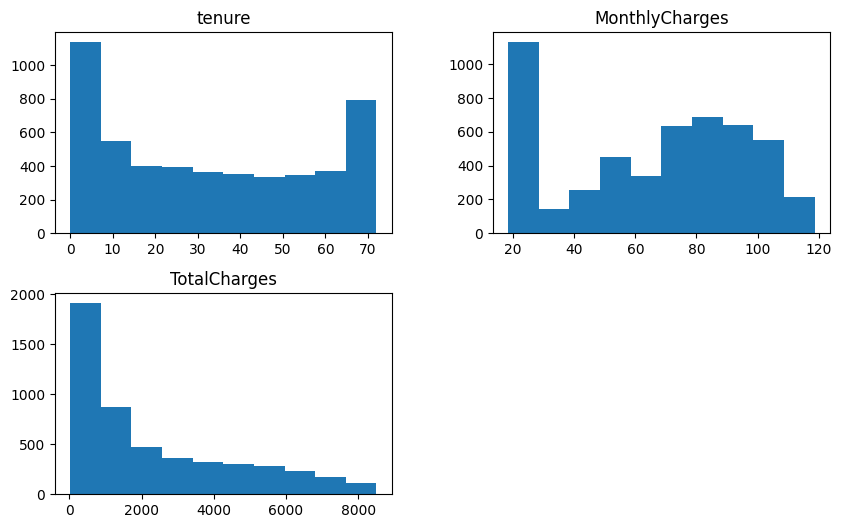

In [496]:
data.hist(figsize=(10, 6), grid=False)
plt.show()

#### Multivariate Analysis

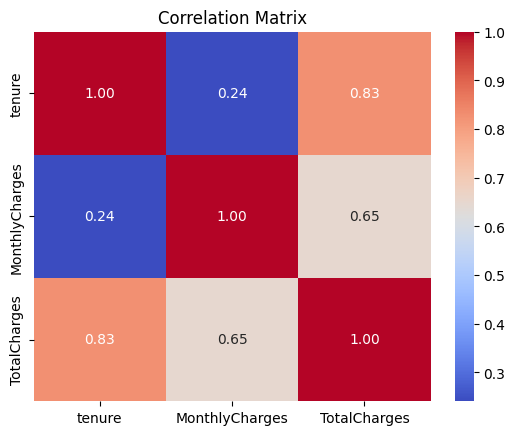

In [497]:
# Correlation matrix for numeric columns
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
correlation_matrix = data[numeric_columns].corr()

# Heatmap of correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


### Answering Analytical Questions

#### 1. What payment methods do customers use the most?

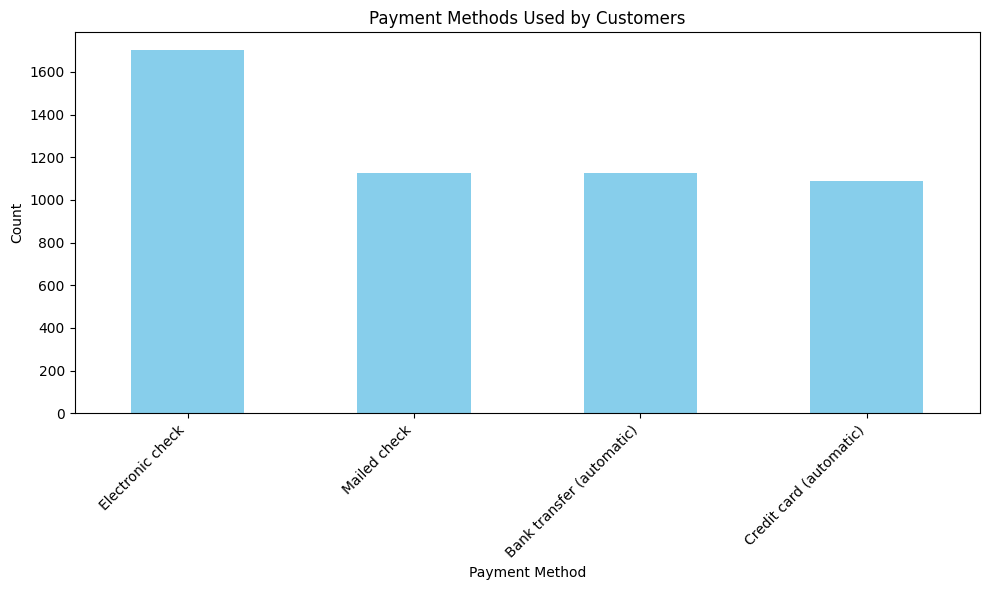

In [498]:
# Calculate the counts of each payment method
payment_counts = data['PaymentMethod'].value_counts()

plt.figure(figsize=(10, 6))
payment_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.title('Payment Methods Used by Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 2. What proportion of customers are male and what proportion are female?

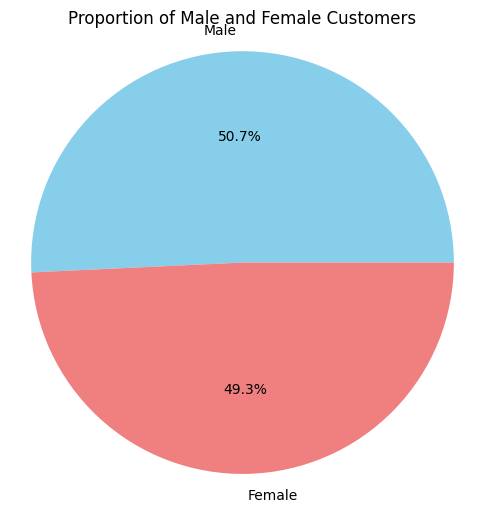

In [499]:
# Calculate the proportion of male and female customers
gender_counts = data['gender'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Proportion of Male and Female Customers')
plt.axis('equal')
plt.show()


#### 3. Are customers with internet service more or less likely to churn compared to those without?

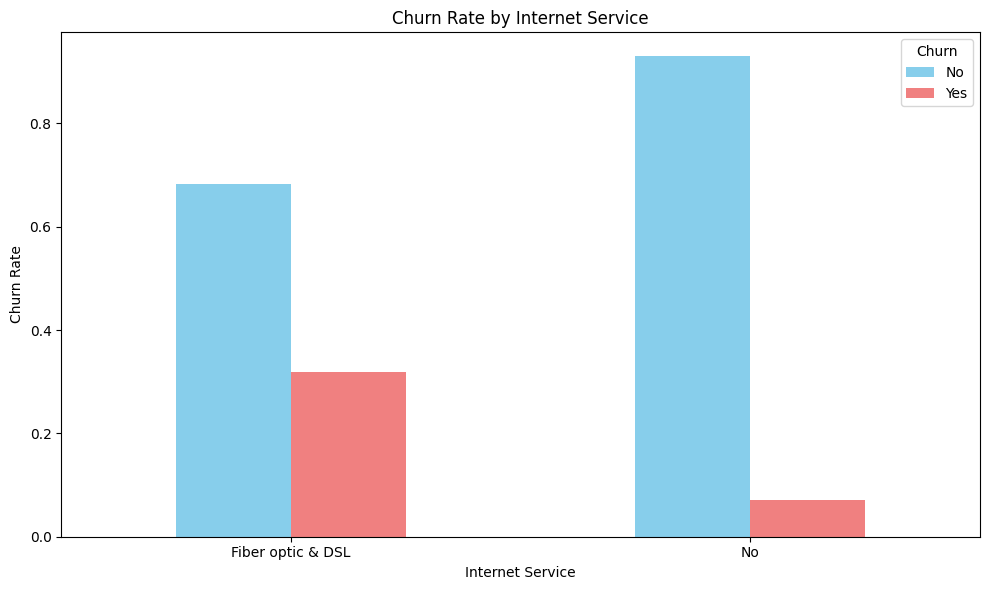

In [500]:
# Map values to 'No' and 'Others'
data['InternetService'] = data['InternetService'].map({'No': 'No', 'DSL': 'Fiber optic & DSL', 'Fiber optic': 'Fiber optic & DSL'})

# Calculate churn rates for 'No' and 'Others' categories
churn_rates = data.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()

churn_rates.plot(kind='bar', color=['skyblue', 'lightcoral'], figsize=(10, 6))
plt.xlabel('Internet Service')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Internet Service')
plt.xticks(rotation=0)
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()


#### 4. How does the tenure vary across different contract types?

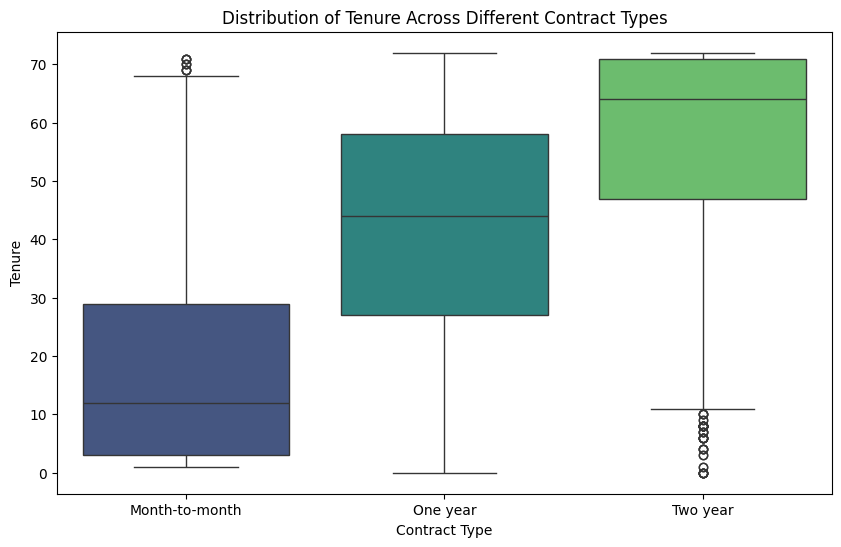

In [501]:
# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Contract', y='tenure', data=data, palette='viridis')
plt.xlabel('Contract Type')
plt.ylabel('Tenure')
plt.title('Distribution of Tenure Across Different Contract Types')
plt.show()


#### 5. How does the type of contract affect the rate of churn?

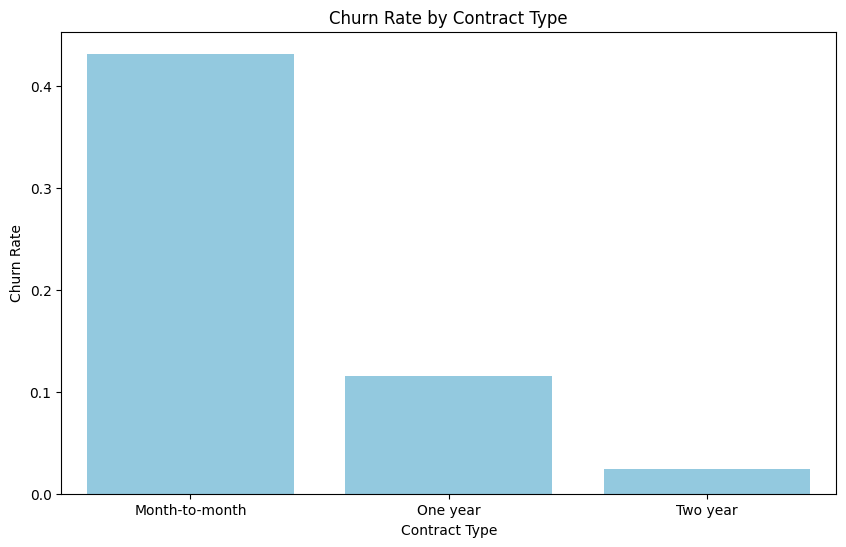

In [502]:
# Map 'Churn' values to binary (1 for 'Yes', 0 for 'No')
data['Churn_binary'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Calculate churn rates by contract type
churn_rates = data.groupby('Contract')['Churn_binary'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rates, x='Contract', y='Churn_binary', color='skyblue')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Contract Type')
plt.show()

# Drop the temporary column
data.drop('Churn_binary', axis=1, inplace=True)



### Hypothesis Testing

#### Null Hypothesis (H0): There is no significant difference in churn rates between different contract types.
#### Alternative Hypothesis (H1): There is significant difference in churn rates between different contract types.

ANOVA test results:
F-statistic: 12.588554472166203
P-value: 0.023840612054365103
Reject the null hypothesis: There is significant difference in churn rates between different contract types.


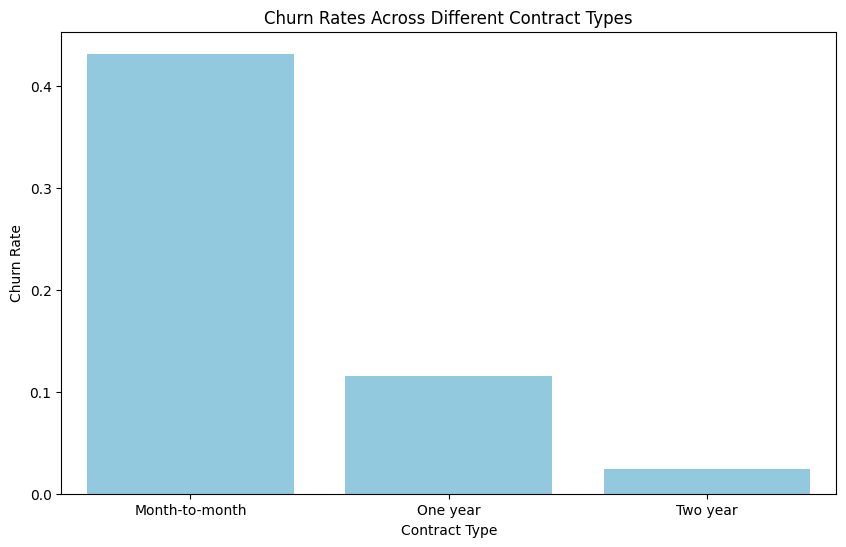

In [503]:
# Calculate churn rates by contract type
churn_rates = data.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()

# Perform ANOVA
f_statistic, p_value = f_oneway(*[churn_rates[col] for col in churn_rates.columns])

# Set significance level (alpha)
alpha = 0.05

# Print ANOVA results
print("ANOVA test results:")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Check for significance
if p_value < alpha:
    print("Reject the null hypothesis: There is significant difference in churn rates between different contract types.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in churn rates between different contract types.")


plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rates.reset_index(), x='Contract', y='Yes', color='skyblue')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.title('Churn Rates Across Different Contract Types')
plt.show()


#### Conclusion
Based on the analysis and the ANOVA test results, we reject the null hypothesis, indicating a significant difference in churn rates between different contract types. The bar plot illustrates varying churn rates across contract types, with a notably higher churn rate observed among customers with a Month-to-Month contract. This finding suggests that contract terms significantly impact customer retention. To improve customer retention strategies, the marketing department should consider tailoring efforts to address the needs and preferences associated with different contract types. Specifically, for customers with a Month-to-Month contract, efforts should be made to encourage consideration of longer-term contracts, such as one year or two years. Targeted communication and incentives could be employed to promote long-term commitment and reduce churn within specific contract segments.